# Зависимости

In [28]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.transforms import v2
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import make_grid
import torch.nn.functional as F

import matplotlib.pyplot as plt

from typing import Optional, Callable, Tuple, List, Optional
from tqdm.notebook import tqdm, tnrange
import gc
import copy
import random as rn

from pathlib import Path
import shutil
import os

from itertools import combinations, product, batched

# 1. Подготовка набора данных

Используется набор данных с предшествующего этапа обработки (фильтрация исходного до 20к, обрезка по координатам "ббоксов", предсказание ключевых точек, выравнивание по трем ключевым точкам с приведением размера к 256х256 и константным серым паддингом).

Дополнительная обрезка проводится на стадии сборки датасетов.

Дополнительно выделяется тестовый набор.

In [ ]:
# загрузка набора `aligned_pred` с лицами, выровненными на основе предсказанных
# SHN лендмарков и разбитыми по папкам с именами классов (1004, 2507 и т.д.)
!gdown 1lOMiFMOBAUD6TbTczYkQVdpAXZWdqGuv

# распаковка и удаление архива (359 мб)
!unzip -q aligned_pred.zip
!rm aligned_pred.zip

Downloading...
From (original): https://drive.google.com/uc?id=1lOMiFMOBAUD6TbTczYkQVdpAXZWdqGuv
From (redirected): https://drive.google.com/uc?id=1lOMiFMOBAUD6TbTczYkQVdpAXZWdqGuv&confirm=t&uuid=8465c571-fd80-43a9-9e95-cba0274de696
To: /kaggle/working/aligned_pred.zip
100%|████████████████████████████████████████| 359M/359M [00:04<00:00, 84.4MB/s]


In [2]:
# загрузка файла `aligned.csv` с именами файлов (`image_id`) и их метками классов (`identity`)
!gdown 1rd8vO2hpZaLPe85CyKzlPvJFHV3YZdIe

Downloading...
From: https://drive.google.com/uc?id=1rd8vO2hpZaLPe85CyKzlPvJFHV3YZdIe
To: /content/aligned.csv
100% 319k/319k [00:00<00:00, 114MB/s]


In [5]:
df_aligned = pd.read_csv('aligned.csv', index_col=False)
df_aligned

image_id  identity
0      000007.jpg      9040
1      000018.jpg      2464
2      000024.jpg      9290
3      000051.jpg      1446
4      000052.jpg      3896
...           ...       ...
19995  202548.jpg      7095
19996  202559.jpg      5768
19997  202560.jpg      6494
19998  202561.jpg      8787
19999  202581.jpg      7902

[20000 rows x 2 columns]

## Формирование отложенной выборки

In [6]:
# всего уникальных классов в наборе
df_aligned.identity.nunique()

1000

In [7]:
# Выделение 100 классов (1999 изображений, в среднем по 20 на класс) в отложенную выборку
seed_value = 42
rng = np.random.default_rng(seed_value)

holdout_sample = rng.choice(df_aligned.identity.unique(), 100, replace=False)
df_aligned_test = df_aligned.query('identity in @holdout_sample')

df_aligned_trainval = df_aligned.drop(df_aligned_test.index).reset_index(drop=True)
df_aligned_test = df_aligned_test.reset_index(drop=True)

In [8]:
# эти классы модель не увидит
holdout_sample

array([ 5847,  6824,  5968,  5983,  7923,  5700,  2263,  4478,  4304,
        8817,   825,  4435,  1942,  1614,  4853,  4164,  3665,  6404,
        1133,  9463,  6100,   981,  1588,  1711,  6637,  1011,  4860,
        3853,  9086,  6066,  2768,    94,  5930,  6702,  7538,  5704,
        1832,  1560,  4920,  4842,  7193,  1188, 10160,  8910, 10134,
        4119,  2295,  7174,  1031,  6698,  6751,  3547,  1008,  7726,
        1835,  5283,  1934,  8712,  1672,  3278,   289,  5254,  4358,
         143,  6128,  8141,  7596,  7044,  7275,  6921,  8297,  3035,
        9577,  2017,  4849,  8770,  2014,  8212,  6876,  3725,  4161,
         826,  2119,  7691,  2900,   481,  9065,  7158,  9610,  2425,
        6575,  3119,  7013,  4135,   871,  3959,  8947,  2561,  7569,
        2888])

In [9]:
# этот набор данных будет использоваться для обучения модели face recognition
df_aligned_trainval

image_id  identity
0      000007.jpg      9040
1      000018.jpg      2464
2      000024.jpg      9290
3      000051.jpg      1446
4      000052.jpg      3896
...           ...       ...
17996  202548.jpg      7095
17997  202559.jpg      5768
17998  202560.jpg      6494
17999  202561.jpg      8787
18000  202581.jpg      7902

[18001 rows x 2 columns]

In [10]:
# этот набор данных не будет использоваться в обучении модели
df_aligned_test

image_id  identity
0     000633.jpg      9577
1     000836.jpg      3725
2     000917.jpg      7174
3     000997.jpg       143
4     001022.jpg      7044
...          ...       ...
1994  201969.jpg      9086
1995  202001.jpg      5968
1996  202016.jpg      7193
1997  202183.jpg      6824
1998  202376.jpg      9086

[1999 rows x 2 columns]

In [11]:
# уникальных классов в наборах
df_aligned_trainval.identity.nunique(), df_aligned_test.identity.nunique()

(900, 100)

In [12]:
# сохранение отложенной выборки
df_aligned_test.to_csv('df_aligned_test.csv', index=False)

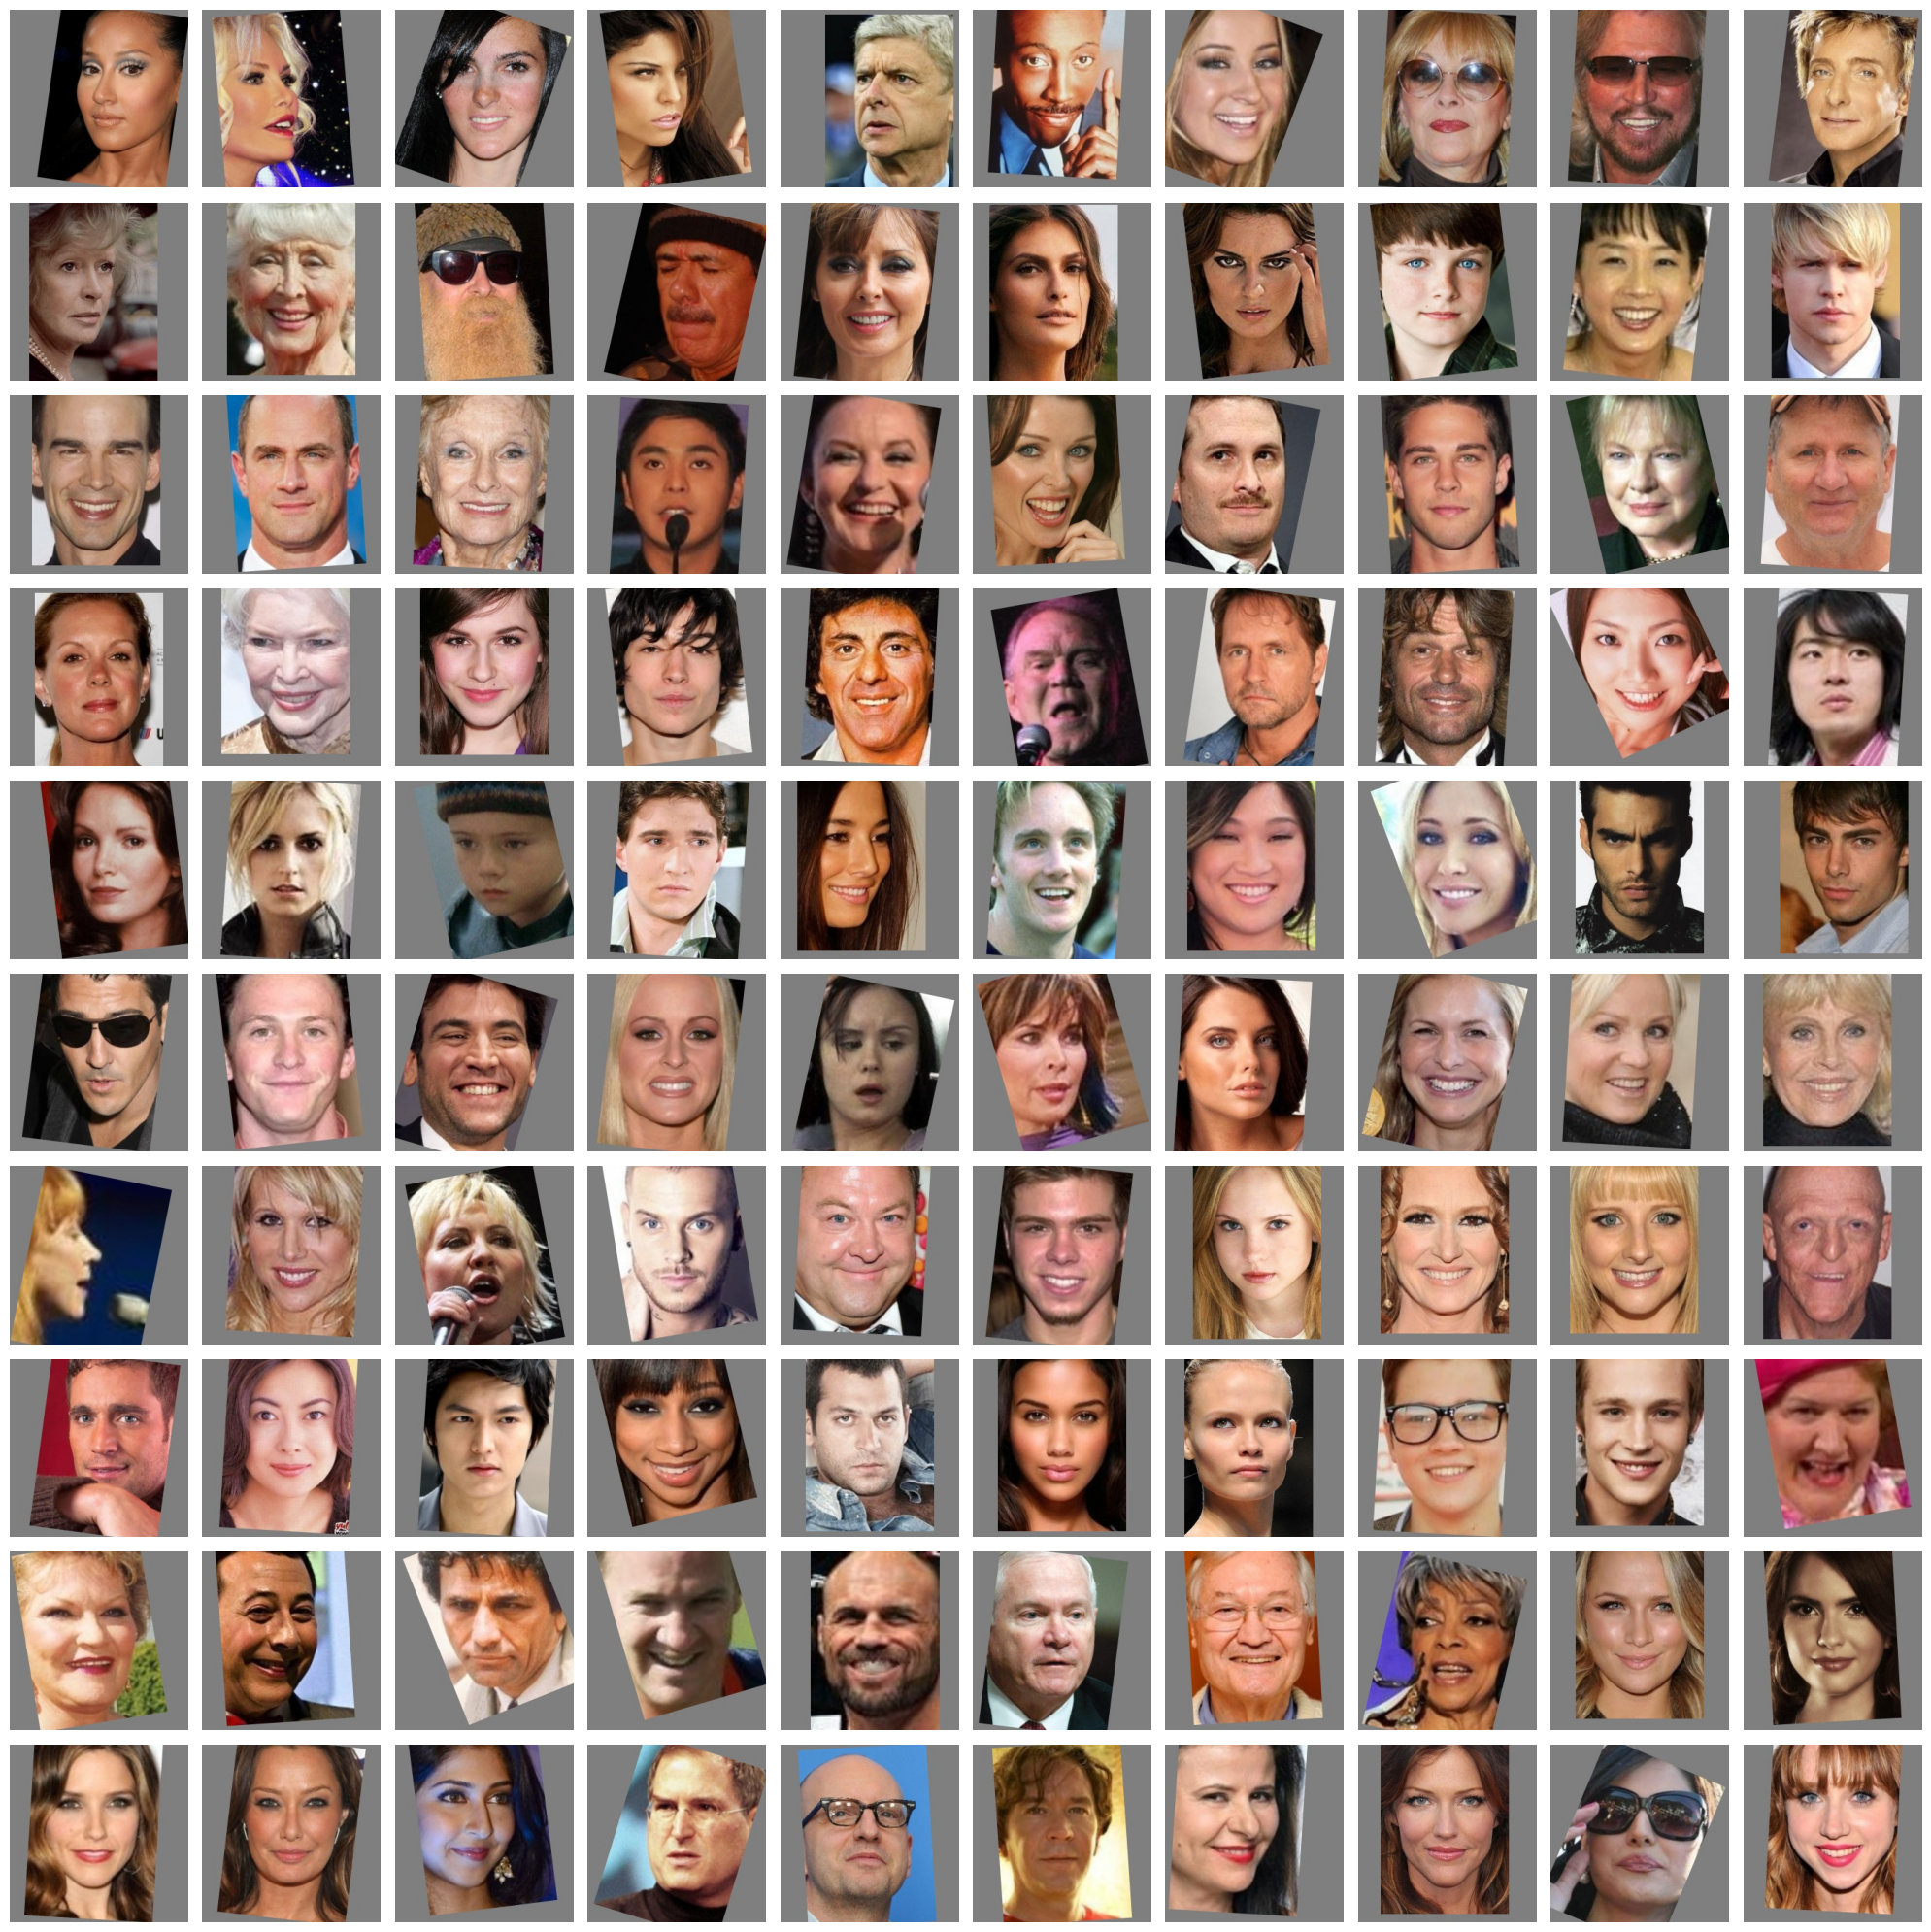

In [ ]:
# вывод по одному изображению на каждый класс отложенной выборки. никого из этих 100 людей модель не увидит при обучении
df_sample_100 = df_aligned_test.groupby('identity').sample(1, random_state=42)
images_ = []
for _, (image_id, identity) in df_sample_100.iterrows():
    image_ = Image.open(os.path.join('aligned_pred', str(identity), image_id)).convert('RGB')
    images_.append(image_)
    # break

fig, ax = plt.subplots(10, 10, figsize=(20, 20))
ax = ax.flatten()
for i, img_ in enumerate(images_):
    ax[i].imshow(img_)
    ax[i].axis('off')
fig.tight_layout()
fig.show()

## Функция для разбиения набора

In [ ]:
def create_baseline_split(
    df_: pd.DataFrame,
    images_root: str,
    output_root: str,
    val_ratio: float = 0.2,
    min_images_per_class: int = 10,
    random_seed: int = 42
) -> pd.DataFrame:
    """
    Создаёт разбиение ДЛЯ БЕЙЗЛАЙНА (CE Loss):
        - Все классы присутствуют в train и val
        - Разбиение по изображениям ВНУТРИ каждого класса
        - Test не создаётся (для бейзлайна не нужен)

    Args:
        csv_path: путь к aligned_pred.csv
        images_root: исходная директория с изображениями
        output_root: целевая директория
        val_ratio: доля изображений на класс для валидации (0.2 = 20%)
        min_images_per_class: минимальное число изображений на класс

    Returns:
        Датафрейм с колонками ['filepath', 'class_id', 'class_name', 'split']
    """
    np.random.seed(random_seed)

    # 1. Загрузка и фильтрация
    df = df_.copy()
    class_counts = df['identity'].value_counts()
    valid_classes = class_counts[class_counts >= min_images_per_class].index
    filtered_df = df[df['identity'].isin(valid_classes)].copy()

    print(f"Фильтрация: {len(filtered_df)} изображений, {len(valid_classes)} классов")

    # 2. Создание маппинга классов
    class_to_id = {cls: idx for idx, cls in enumerate(sorted(valid_classes))}

    # 3. Разбиение ПО ИЗОБРАЖЕНИЯМ внутри каждого класса
    records = []
    output_root = Path(output_root)
    output_root.mkdir(parents=True, exist_ok=True)

    for identity in valid_classes:
        class_df = filtered_df[filtered_df['identity'] == identity].copy()
        n_total = len(class_df)
        n_val = max(1, int(n_total * val_ratio))  # минимум 1 изображение в вале

        # Случайный выбор изображений для валидации
        val_sample = class_df.sample(n=n_val, random_state=random_seed)
        train_sample = class_df.drop(val_sample.index)

        # Обработка трейна
        for _, row in train_sample.iterrows():
            _copy_image_and_record(
                row, 'train', class_to_id[identity],
                images_root, output_root, records
            )

        # Обработка валидации
        for _, row in val_sample.iterrows():
            _copy_image_and_record(
                row, 'val', class_to_id[identity],
                images_root, output_root, records
            )

    # 4. Создание итогового датафрейма
    final_df = pd.DataFrame(records)
    final_df.to_parquet(output_root / 'metadata_baseline.parquet', index=False)

    # Статистика
    train_count = len(final_df[final_df['split'] == 'train'])
    val_count = len(final_df[final_df['split'] == 'val'])
    print(f"   Train: {train_count} изображений ({final_df[final_df['split']=='train']['class_name'].nunique()} классов)")
    print(f"   Val:   {val_count} изображений ({final_df[final_df['split']=='val']['class_name'].nunique()} классов)")

    return final_df

def _copy_image_and_record(row, split, class_id, images_root, output_root, records):
    """Вспомогательная функция для копирования изображения и добавления записи."""
    img_name = row['image_id']
    identity = str(row['identity'])

    src_path = Path(images_root) / identity / img_name
    dst_dir = output_root / split / identity
    dst_dir.mkdir(parents=True, exist_ok=True)
    dst_path = dst_dir / img_name

    shutil.copy2(src_path, dst_path)

    records.append({
        'filepath': str(dst_path.relative_to(output_root)),
        'class_id': class_id,
        'class_name': identity,
        'split': split
    })

## Dataset

In [13]:
# используется модель ResNet18, предобученная на наборе ImageNet,
# и, отсюда, статистики указанного набора для (де)нормализации
imagenet_stats = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def denormalize(images):
  mean = torch.tensor(imagenet_stats['mean']).view(-1, 1, 1).to(images.device)
  std = torch.tensor(imagenet_stats['std']).view(-1, 1, 1).to(images.device)
  return (images * std + mean).clamp(0, 1)

In [ ]:
class FaceDataset(Dataset):
    """
    Датасет для загрузки выровненных изображений лиц.
    Работает напрямую с датафреймом метаданных.
    Аугментации только для трейна (валидация/тест = без искажений).
    Нормализация под предобученные модели torchvision (ImageNet stats)
    """

    def __init__(
        self,
        df: pd.DataFrame,
        root_dir: str,
        transform: Optional[Callable] = None,
        split: str = 'train'
    ):
        """
        Args:
            df: датафрейм с колонками ['filepath', 'class_id', 'class_name', 'split']
            root_dir: корневая директория датасета (где лежат train/val/test)
            transform: torchvision-трансформации (если None, то используются дефолтные для сплита)
            split: 'train', 'val' или 'test' -- определяет набор аугментаций по умолчанию
        """
        self.df = df.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.split = split

        # Если алгоритм преобразований не задан, то используется дефолтный для сплита
        self.transform = transform if transform is not None else self._get_default_transforms(split)

    def _get_default_transforms(self, split: str) -> Callable:
        """Возвращает стандартные трансформации для каждого сплита."""
        # Базовые преобразования для всех сплитов: ресайз до 224×224 + нормализация
        base_transforms = [
            v2.CenterCrop(160), # дополнительный кроп для обрезания неинформативных краев
            v2.Resize((224, 224), interpolation=v2.InterpolationMode.BILINEAR),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),  # Масштабирование [0,255] -> [0,1]
            v2.Normalize(**imagenet_stats)
        ]

        # при обучении: аугментация
        if split == 'train':
            train_transforms = [
                v2.RandomHorizontalFlip(p=0.5),
                v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
                v2.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.3),
                v2.RandomGrayscale(p=0.05)
                ]

            return v2.Compose(train_transforms + base_transforms)
        else:
            # Для валидации/теста: только детерминированные преобразования
            return v2.Compose(base_transforms)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Returns:
            image: torch.Tensor [3, 224, 224] — нормализованное изображение
            label: int — class_id
        """
        row = self.df.iloc[idx]
        img_path = self.root_dir / row['filepath']

        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        # Метка класса (для бейзлайна с CE Loss используем только трейн с валидными ID)
        label = int(row['class_id'])

        return image, label

## Разбиение набора `trainval` и создание датасетов

In [ ]:
# 18001 изображение `trainval`
DS_DIR = "baseline_dataset"
shutil.rmtree(DS_DIR, ignore_errors=True)

# 1. Создание разбиения
df = create_baseline_split(
    df_=df_aligned_trainval,
    images_root="aligned_pred",
    output_root=DS_DIR,
    val_ratio=0.2,
    random_seed=42
)

# 2. Создание датасетов
train_df = df.query('split == "train"')
val_df = df.query('split == "val"')
train_ds = FaceDataset(df=train_df, root_dir=DS_DIR, split='train')
val_ds = FaceDataset(df=val_df, root_dir=DS_DIR, split='val')

Фильтрация: 18001 изображений, 900 классов
   Train: 14454 изображений (900 классов)
   Val:   3547 изображений (900 классов)


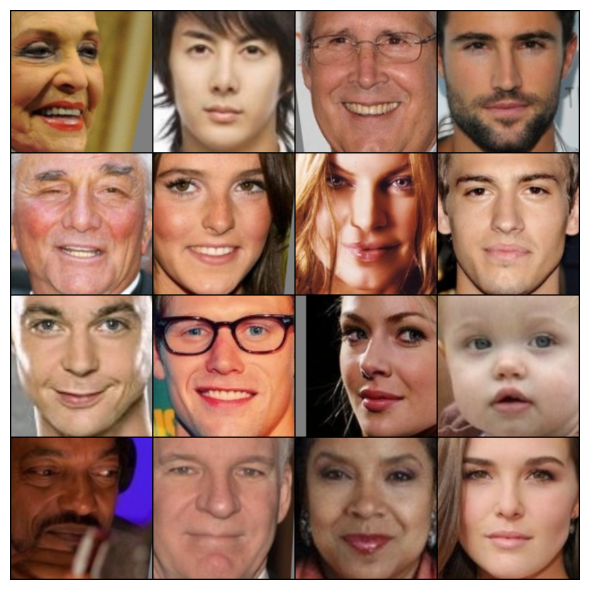

In [ ]:
# пример загрузчика и вывод случайных изображений из валидационного набора после базовых трансформаций
loader = DataLoader(val_ds, batch_size=16, shuffle=True)

images, labels = next(iter(loader))
images = denormalize(images)

grid_img = make_grid(images, nrow=4)

plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Baseline: CE loss

## Архитектура и сборка модели

In [14]:
def create_face_recognition_model(
    num_classes: int,
    embedding_size: int = 512,
    pretrained: bool = True,
    freeze_backbone: bool = False
) -> nn.Module:
    """
    Создаёт модель для распознавания лиц на основе ResNet18.

    Архитектурные особенности:
        - Замена первого свёрточного слоя для оптимальной работы с 224*224
        - Замена полносвязного слоя на два последовательных слоя:
            1. Эмбеддинг-слой (512 → embedding_size)
            2. Классификационный слой (embedding_size → num_classes)
        - L2-нормализация эмбеддингов (опционально, для совместимости с ArcFace)

    Args:
        num_classes: число классов в трейне
        embedding_size: размерность эмбеддинг-вектора (512 — для сопоставления с ArcFace)
        pretrained: использовать ImageNet веса
        freeze_backbone: заморозить все слои кроме головы (для быстрого эксперимента)

    Returns:
        Модель с атрибутами:
            - backbone: основная часть ResNet18 (до avgpool)
            - embedding_layer: Linear(512, embedding_size)
            - classifier: Linear(embedding_size, num_classes)
    """
    # 1. Загрузка предобученной на ImageNet модели
    if pretrained:
        weights = ResNet18_Weights.IMAGENET1K_V1
        model = resnet18(weights=weights)
    else:
        model = resnet18()

    # 2. Оптимизация первого свёрточного слоя под 224*224
    # Стандартный ResNet18: Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
    # Для 224*224 даёт feature map 56*56 после первого слоя

    # 3. Сохранение backbone (всё до avgpool)
    backbone = nn.Sequential(
        model.conv1, model.bn1, model.relu,
        model.maxpool,
        model.layer1, model.layer2, model.layer3, model.layer4,
        model.avgpool
    )

    # 4. Эмбеддинг-слой и голова классификатора
    embedding_layer = nn.Linear(512, embedding_size)
    classifier = nn.Linear(embedding_size, num_classes)

    # 5. Инициализация весов новых слоёв
    nn.init.xavier_uniform_(embedding_layer.weight)
    nn.init.zeros_(embedding_layer.bias)
    nn.init.xavier_uniform_(classifier.weight)
    nn.init.zeros_(classifier.bias)

    # 6. Сборка финальной модели
    class FaceRecognitionModel(nn.Module):
        def __init__(self, backbone, embedding_layer, classifier):
            super().__init__()
            self.backbone = backbone
            self.embedding_layer = embedding_layer
            self.classifier = classifier

        def forward(self, x, return_embeddings=False):
            """
            Args:
                x: входной тензор [B, 3, 224, 224]
                return_embeddings: если True — возвращает (logits, embeddings), иначе только logits

            Returns:
                logits: [B, num_classes] — выходы классификатора
                embeddings: [B, embedding_size] — L2-нормализованные эмбеддинги (если return_embeddings=True)
            """
            features = self.backbone(x)  # [B, 512, 1, 1]
            features = torch.flatten(features, 1)  # [B, 512]
            embeddings = self.embedding_layer(features)  # [B, embedding_size]

            if return_embeddings:
                # L2-нормализация для совместимости с метрическим обучением
                embeddings_norm = torch.nn.functional.normalize(embeddings, p=2, dim=1)
                logits = self.classifier(embeddings_norm)
                return logits, embeddings_norm
            else:
                logits = self.classifier(embeddings)
                return logits

    model = FaceRecognitionModel(backbone, embedding_layer, classifier)

    # 7. Заморозка backbone при необходимости
    if freeze_backbone:
        for param in model.backbone.parameters():
            param.requires_grad = False

    return model

## Служебные функции

In [15]:
# Утилита для загрузки модели с сохранением чекпоинтов
def load_model_for_training(
    num_classes: int,
    checkpoint_path: str = None,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    **model_kwargs
) -> Tuple[nn.Module, dict]:
    """
    Загружает модель для тренировки с возможностью восстановления из чекпоинта.

    Args:
        num_classes: число классов
        checkpoint_path: путь к чекпоинту (если None — создаёт новую модель)
        device: устройство для загрузки
        **model_kwargs: параметры для create_face_recognition_model

    Returns:
        model: загруженная модель
        metadata: словарь с метаданными (epoch, best_acc и т.д.)
    """
    if checkpoint_path is not None:
        print(f"Загрузка модели из чекпоинта: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Восстановление модели
        model = create_face_recognition_model(
            num_classes=num_classes,
            **model_kwargs
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

        # Метаданные для продолжения обучения
        metadata = {
            'epoch': checkpoint.get('epoch', 0),
            'best_acc': checkpoint.get('best_acc', 0.0),
            'optimizer_state_dict': checkpoint.get('optimizer_state_dict', None)
        }
    else:
        print("Создание новой модели с предобученными весами...")
        model = create_face_recognition_model(num_classes=num_classes, **model_kwargs)
        model.to(device)
        metadata = {'epoch': 0, 'best_acc': 0.0}

    return model, metadata

In [ ]:
def clear_memory():
    """Очистка кэша графического ускорителя и сбор мусора"""
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
    gc.collect()

@torch.no_grad()
def calculate_accuracy(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """
    Вычисляет top-1 accuracy.

    Args:
        outputs: [B, num_classes] — logits
        labels: [B] — ground truth labels

    Returns:
        Top-1 accuracy в процентах
    """
    # Удаляем недопустимые метки (class_id = -1)
    valid_mask = labels != -1
    if not valid_mask.any():
        return 0.0

    outputs = outputs[valid_mask]
    labels = labels[valid_mask]
    batch_size = labels.size(0)

    if batch_size == 0:
        return 0.0

    # Top-1 prediction
    pred = outputs.argmax(dim=1)  # [B]
    correct = pred.eq(labels).float().sum().item()
    accuracy = correct * 100.0 / batch_size

    return accuracy

In [ ]:
def fit_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler):
    """Тренировочная эпоха с поддержкой mixed precision."""
    model.train()

    num_batches = len(train_loader)
    epoch_loss = 0.0
    epoch_top1 = 0.0

    for images, labels in tqdm(train_loader, desc='Train', leave=False):
        # Удаляем недопустимые метки (должны отсутствовать в трейне, но на всякий случай)
        valid_mask = labels != -1
        if not valid_mask.any():
            continue

        images = images[valid_mask].to(device)
        labels = labels[valid_mask].to(device)

        optimizer.zero_grad()

        with torch.autocast(device_type=device.type if hasattr(device, 'type') else 'cuda',
                           dtype=torch.float16 if device.type == 'cuda' else torch.bfloat16):
            outputs = model(images)
            batch_loss = criterion(outputs, labels)

        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Вычисление top-1 accuracy
        top1_acc = calculate_accuracy(outputs, labels)
        epoch_top1 += top1_acc
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / num_batches
    avg_top1 = epoch_top1 / num_batches

    if scheduler and hasattr(scheduler, 'step') and type(scheduler).__name__ != 'ReduceLROnPlateau':
        scheduler.step()

    return avg_loss, avg_top1

def validate_one_epoch(model, val_loader, criterion, device):
    """Валидационная эпоха."""
    model.eval()

    num_batches = len(val_loader)
    epoch_loss = 0.0
    epoch_top1 = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validate', leave=False):
            # Удаляем недопустимые метки (в val/test class_id = -1)
            valid_mask = labels != -1
            if not valid_mask.any():
                continue

            images = images[valid_mask].to(device)
            labels = labels[valid_mask].to(device)

            outputs = model(images)
            batch_loss = criterion(outputs, labels)

            # Вычисление top-1 accuracy
            top1_acc = calculate_accuracy(outputs, labels)
            epoch_top1 += top1_acc
            epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / num_batches
    avg_top1 = epoch_top1 / num_batches

    return avg_loss, avg_top1

def train(model, train_loader, val_loader, n_epochs,
          criterion, optimizer, scheduler,
          device, checkpoint_path: str = 'best_model.pth'
          ):
    """
    Тренировочный цикл с поддержкой mixed precision и сохранением лучших моделей.
    """
    model.to(device)
    scaler = torch.amp.GradScaler() if device.type == 'cuda' else None
    history = {
        'train_loss': [], 'val_loss': [],
        'train_top1': [], 'val_top1': []
    }
    best_val_top1 = 0.0
    best_checkpoint = None

    try:
        for epoch in tnrange(n_epochs, desc='Epochs'):
            # Тренировка
            train_loss, train_top1 = fit_one_epoch(
                model, train_loader, criterion, optimizer, scheduler, device, scaler)

            # Валидация
            val_loss, val_top1 = validate_one_epoch(
                model, val_loader, criterion, device)

            # Обновление планировщика для ReduceLROnPlateau
            if scheduler and type(scheduler).__name__ == 'ReduceLROnPlateau':
                scheduler.step(val_loss)

            # Логирование
            print(f'Epoch {epoch + 1}:')
            print(f'  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
            print(f'  Train Top-1: {train_top1:.2f}% | Val Top-1: {val_top1:.2f}%')

            # Сохранение истории
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_top1'].append(train_top1)
            history['val_top1'].append(val_top1)

            # Сохранение лучшей модели по top-1 accuracy
            if val_top1 > best_val_top1:
                best_val_top1 = val_top1
                best_checkpoint = {
                    'model_state_dict': copy.deepcopy(model.state_dict()),
                    'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'history': copy.deepcopy(history),
                    'epoch': epoch,
                    'best_val_top1': best_val_top1
                }
                torch.save(best_checkpoint, checkpoint_path)
                print(f'==Best model updated (top-1: {best_val_top1:.2f}%)==')

    except KeyboardInterrupt:
        clear_memory()
        print("\nKeyboard interrupted. Saving the current model")
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'epoch': epoch,
            'interrupted': True
        }, 'interrupted_model.pth')
        return model, history

    # Загрузка лучшей модели
    if best_checkpoint:
        model.load_state_dict(best_checkpoint['model_state_dict'])
        print(f"\nBest model loaded (top-1: {best_val_top1:.2f}%)")

    return model, history

## Обучение

In [ ]:
# Гиперпараметры
NUM_CLASSES = train_df.class_id.nunique()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 5e-3

# Создание даталоадеров
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          prefetch_factor=2,       # Загружает 2 батча вперёд для скорости
                          )
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2, shuffle=False,
                        num_workers=4,
                        pin_memory=True)

# Создание модели
model = create_face_recognition_model(
    num_classes=NUM_CLASSES,
    embedding_size=512,
    pretrained=True)

# Настройка обучения
criterion = nn.CrossEntropyLoss(label_smoothing=0.3)  # label smoothing для лучшей обобщаемости
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2)

# Запуск
trained_model, history = train(
    model, train_loader, val_loader, NUM_EPOCHS,
    criterion, optimizer, scheduler, DEVICE
    )

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
  Train Loss: 6.4526 | Val Loss: 5.8103
  Train Top-1: 3.99% | Val Top-1: 11.93%
==Best model updated (top-1: 11.93%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2:
  Train Loss: 5.0538 | Val Loss: 4.9428
  Train Top-1: 34.19% | Val Top-1: 35.01%
==Best model updated (top-1: 35.01%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3:
  Train Loss: 4.0817 | Val Loss: 4.2398
  Train Top-1: 69.30% | Val Top-1: 60.71%
==Best model updated (top-1: 60.71%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4:
  Train Loss: 3.5457 | Val Loss: 4.0851
  Train Top-1: 87.98% | Val Top-1: 67.43%
==Best model updated (top-1: 67.43%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5:
  Train Loss: 3.2720 | Val Loss: 3.9381
  Train Top-1: 95.53% | Val Top-1: 71.80%
==Best model updated (top-1: 71.80%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6:
  Train Loss: 3.1316 | Val Loss: 3.8381
  Train Top-1: 98.44% | Val Top-1: 75.90%
==Best model updated (top-1: 75.90%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7:
  Train Loss: 3.0521 | Val Loss: 3.8098
  Train Top-1: 99.33% | Val Top-1: 77.47%
==Best model updated (top-1: 77.47%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8:
  Train Loss: 3.0063 | Val Loss: 3.7915
  Train Top-1: 99.58% | Val Top-1: 78.09%
==Best model updated (top-1: 78.09%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9:
  Train Loss: 2.9722 | Val Loss: 3.7575
  Train Top-1: 99.83% | Val Top-1: 79.20%
==Best model updated (top-1: 79.20%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10:
  Train Loss: 2.9462 | Val Loss: 3.7298
  Train Top-1: 99.90% | Val Top-1: 80.58%
==Best model updated (top-1: 80.58%)==

Best model loaded (top-1: 80.58%)


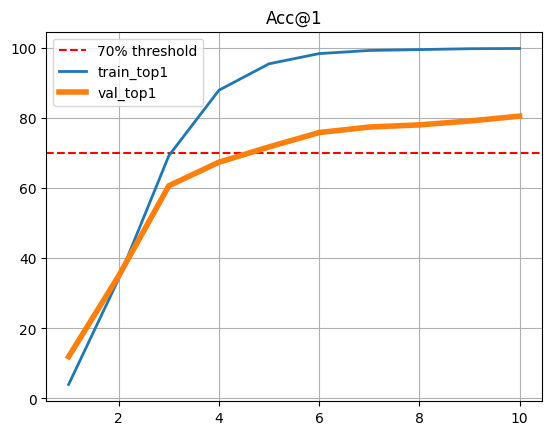

In [ ]:
plt.figure()
plt.axhline(70, color='red', ls='--', label='70% threshold')
for lw, (k, v) in enumerate(list(history.items())[2:], start=1):
  plt.plot(range(1, 11), v, label=k, lw=lw * 2)
plt.title('Acc@1')
plt.grid()
plt.legend();

## Загрузка обученной модели и демонстрация

In [19]:
!gdown 1JS-qiBff163-0wTMQJ08hkGtQnWxzWgb

Downloading...
From (original): https://drive.google.com/uc?id=1JS-qiBff163-0wTMQJ08hkGtQnWxzWgb
From (redirected): https://drive.google.com/uc?id=1JS-qiBff163-0wTMQJ08hkGtQnWxzWgb&confirm=t&uuid=fb8822c4-f6aa-4051-a53f-79ea1952d165
To: /content/ce_loss_baseline_model (best_model.pth).pth
100% 143M/143M [00:04<00:00, 33.3MB/s]


In [20]:
model_, metadata_ = load_model_for_training(
    num_classes=NUM_CLASSES,
    checkpoint_path='ce_loss_baseline_model (best_model.pth).pth')

Загрузка модели из чекпоинта: ce_loss_baseline_model (best_model.pth).pth
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


In [ ]:
batch_size_ = 24
loader_ = DataLoader(val_ds, batch_size=batch_size_, shuffle=True)
load_ = iter(loader_)

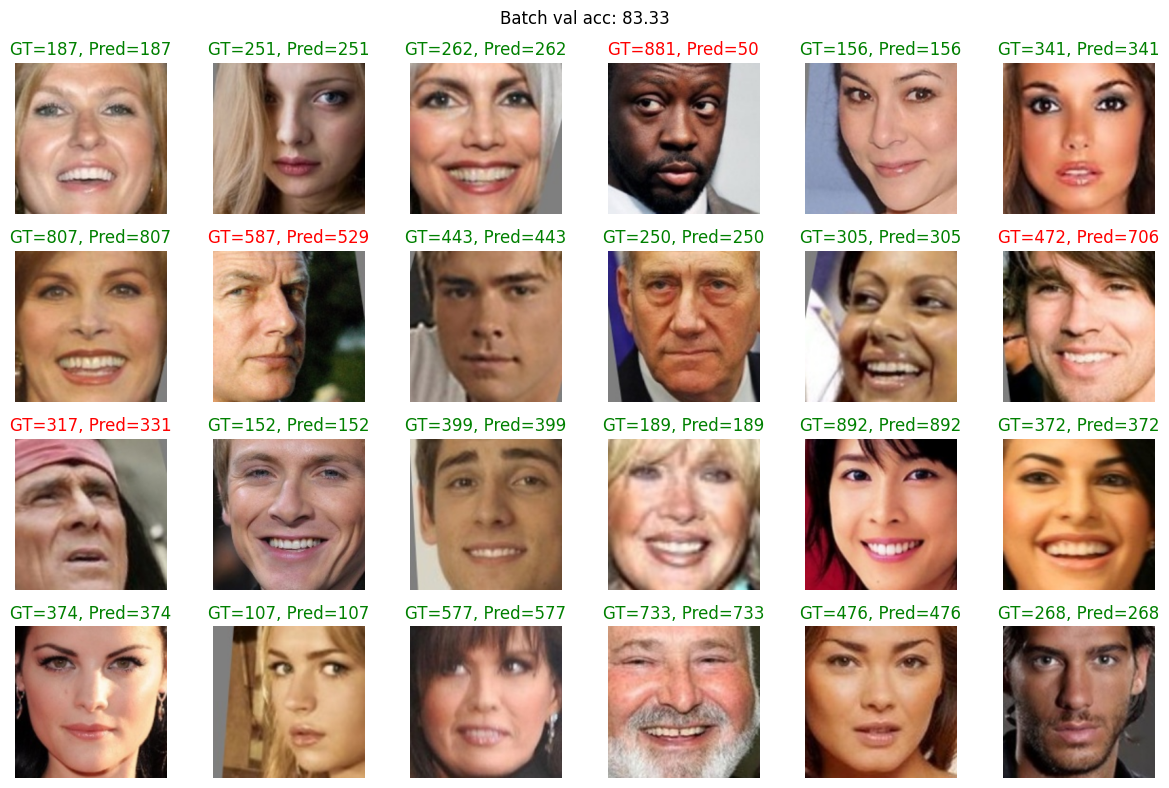

In [ ]:
model_.eval()

with torch.no_grad():
    images, labels = next(load_)
    logits = model_(images.to(DEVICE))
    preds = logits.cpu().argmax(1)

images = denormalize(images)

batch_val_acc = calculate_accuracy(logits, labels.cuda())

fig, ax = plt.subplots(4, 6, figsize=(12, 8))
ax = ax.flatten()
for i, img in enumerate(images):
    ax[i].imshow(img.permute(1,2,0));
    ax[i].axis('off')
    label, pred = labels[i], preds[i]
    c = 'green' if label == pred else 'red'
    ax[i].set_title(f'GT={label}, Pred={pred}', color=c)
fig.suptitle(f'Batch val acc: {(batch_val_acc):.2f}')
fig.tight_layout()

fig.show()

Бэйзлайн-модель успешно (**val_acc@1 = 80.58%**) справляется с распознаванием и классификацией лиц. Требуемый порог в 70% пройден.

# 2. ArcFace

## Слой ArcFace

In [21]:
class ArcFaceLayer(nn.Module):
    """
    ArcFace слой для обучения и валидации.
    Используется как замена последнему Linear-слою в классификации.
    """
    def __init__(self, in_features, out_features, s=32.0, m=0.2):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        # Веса классов (нормализуются в forward)
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, embeddings, labels=None):
        """
        Args:
            embeddings: [B, in_features] — эмбеддинги из backbone
            labels: [B] — метки классов (обязательны при обучении, опциональны при валидации)

        Returns:
            logits: [B, out_features] — модифицированные логиты для CrossEntropy
        """
        # Нормализация
        embeddings = F.normalize(embeddings, dim=1)  # [B, D]
        weight = F.normalize(self.weight, dim=1)     # [C, D]

        # Косинусы между всеми парами и клиппинг
        cos_theta = F.linear(embeddings, weight)
        cos_theta = cos_theta.clamp(-1.0, 1.0)

        # При валидации -- обычные косинусы без маржина
        if labels is None:
            return self.s * cos_theta

        with torch.no_grad():
            # Извлекаем cos для целевых классов
            cos_target = cos_theta[range(len(labels)), labels]  # [B]
            # Вычисляем theta и модифицируем
            theta = torch.acos(cos_target)
            cos_theta_target = torch.cos(theta + self.m)  # [B]
            # Создаём дельту для замены
            delta = cos_theta_target - cos_target  # [B]
            # Расширяем до [B, C]
            delta = delta.unsqueeze(1).expand_as(cos_theta)
            # Создаём маску для целевых классов
            mask = torch.zeros_like(cos_theta)
            mask[range(len(labels)), labels] = 1.0

        # Применяем модификацию к целевым классам
        cos_theta_final = cos_theta + delta * mask
        logits = self.s * cos_theta_final
        return logits

## Архитектура и сборка модели

In [23]:
def create_arcface_model(
    num_classes: int,
    embedding_size: int = 256,
    pretrained: bool = True,
    s: float = 30.0,
    m: float = 0.5
) -> nn.Module:
    """
    Модель с ArcFace-слоем.
    """
    from torchvision.models import resnet18, ResNet18_Weights

    if pretrained:
        weights = ResNet18_Weights.IMAGENET1K_V1
        model = resnet18(weights=weights)
    else:
        model = resnet18()

    backbone = nn.Sequential(
        model.conv1, model.bn1, model.relu, model.maxpool,
        model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool
    )

    # Убираем промежуточный embedding_layer, подаем в ArcFace выход avgpool (512)
    arcface_layer = ArcFaceLayer(512, num_classes, s=s, m=m)  # вход 512, s=30.0 по умолчанию, m=0.5 по умолчанию

    class ArcFaceModel(nn.Module):
        def __init__(self, backbone, arcface_layer):
            super().__init__()
            self.backbone = backbone
            self.arcface_layer = arcface_layer

        def forward(self, x, labels=None, return_embeddings=False):
            """
            Args:
                x: входные изображения [B, 3, H, W]
                labels: метки классов (для обучения)
                return_embeddings: вернуть эмбеддинги вместо логитов

            Returns:
                logits или эмбеддинги
            """
            features = self.backbone(x)
            embeddings = torch.flatten(features, 1)  # [B, 512]

            if return_embeddings:
                return F.normalize(embeddings, p=2, dim=1)

            # Для валидации: labels=None → обычные косинусы
            # Для обучения: labels передаются → ArcFace с маржином
            logits = self.arcface_layer(embeddings, labels)
            return logits

    return ArcFaceModel(backbone, arcface_layer)

## Служебные функции

In [ ]:
# Утилита для загрузки модели с сохранением чекпоинтов
def load_arcface_model_for_training(
    num_classes: int,
    checkpoint_path: str = None,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    **model_kwargs
) -> Tuple[nn.Module, dict]:
    """
    Загружает модель для тренировки с возможностью восстановления из чекпоинта.

    Args:
        num_classes: число классов
        checkpoint_path: путь к чекпоинту (если None — создаёт новую модель)
        device: устройство для загрузки
        **model_kwargs: параметры для `create_arcface_model`

    Returns:
        model: загруженная модель
        metadata: словарь с метаданными (epoch, best_acc и т.д.)
    """
    if checkpoint_path is not None:
        print(f"Загрузка модели из чекпоинта: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Восстановление модели
        model = create_arcface_model(
            num_classes=num_classes,
            **model_kwargs
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)

        # Метаданные для продолжения обучения
        metadata = {
            'epoch': checkpoint.get('epoch', 0),
            'best_acc': checkpoint.get('best_acc', 0.0),
            'optimizer_state_dict': checkpoint.get('optimizer_state_dict', None)
        }
    else:
        print("Создание новой модели с предобученными весами...")
        model = create_arcface_model(num_classes=num_classes, **model_kwargs)
        model.to(device)
        metadata = {'epoch': 0, 'best_acc': 0.0}

    return model, metadata

# загрузка модели для инференса (только эмбеддинги)
def load_arcface_model_for_inference(
    checkpoint_path: str,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> nn.Module:
    """
    Загружает только backbone модели для извлечения эмбеддингов.
    ArcFace-слой отбрасывается.
    """
    print(f"Загрузка backbone из чекпоинта: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Создаём "чистую" модель только с backbone
    class InferenceModel(nn.Module):
        def __init__(self, state_dict):
            super().__init__()
            # Восстанавливаем backbone из state_dict
            from torchvision.models import resnet18, ResNet18_Weights
            model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            self.backbone = nn.Sequential(
                model.conv1, model.bn1, model.relu, model.maxpool,
                model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool
            )
            # Загружаем веса backbone
            backbone_state = {k.replace('backbone.', ''): v
                            for k, v in checkpoint['model_state_dict'].items()
                            if k.startswith('backbone.')}
            self.backbone.load_state_dict(backbone_state)

        def forward(self, x):
            features = self.backbone(x)
            embeddings = torch.flatten(features, 1)
            return F.normalize(embeddings, p=2, dim=1)

    model = InferenceModel(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

Функции ниже преимущественно совпадают с таковыми для бэйзлайн-модели, но не полностью.

In [ ]:
def fit_one_epoch_arcface(model, train_loader, criterion, optimizer, scheduler, device, scaler):
    """Тренировочная эпоха с поддержкой mixed precision для модели с ArcFace."""
    model.train()

    num_batches = len(train_loader)
    epoch_loss = 0.0
    epoch_top1 = 0.0

    for images, labels in tqdm(train_loader, desc='Train', leave=False):
        # Удаляем недопустимые метки (должны отсутствовать в трейне, но на всякий случай)
        valid_mask = labels != -1
        if not valid_mask.any():
            continue

        images = images[valid_mask].to(device, non_blocking=True)
        labels = labels[valid_mask].to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.autocast(device_type=device.type if hasattr(device, 'type') else 'cuda',
                           dtype=torch.float16 if device.type == 'cuda' else torch.bfloat16):
            outputs = model(images, labels=labels)
            batch_loss = criterion(outputs, labels)

        scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Вычисление top-1 accuracy
        top1_acc = calculate_accuracy(outputs, labels)
        epoch_top1 += top1_acc
        epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / num_batches
    avg_top1 = epoch_top1 / num_batches

    if scheduler is not None:
        scheduler.step()

    return avg_loss, avg_top1

def validate_one_epoch_arcface(model, val_loader, criterion, device):
    """Валидационная эпоха для модели с ArcFace."""
    model.eval()

    num_batches = len(val_loader)
    epoch_loss = 0.0
    epoch_top1 = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validate', leave=False):
            # Удаляем недопустимые метки (в val/test class_id = -1)
            valid_mask = labels != -1
            if not valid_mask.any():
                continue

            images = images[valid_mask].to(device, non_blocking=True)
            labels = labels[valid_mask].to(device, non_blocking=True)

            outputs = model(images, labels=None)
            batch_loss = criterion(outputs, labels)

            # Вычисление top-1 accuracy
            top1_acc = calculate_accuracy(outputs, labels)
            epoch_top1 += top1_acc
            epoch_loss += batch_loss.item()

    avg_loss = epoch_loss / num_batches
    avg_top1 = epoch_top1 / num_batches

    return avg_loss, avg_top1

def train_arcface(model, train_loader, val_loader, n_epochs,
                  criterion, optimizer, scheduler, device,
                  checkpoint_path: str = 'best_model_arcface.pth'
                  ):
    """
    Полный тренировочный цикл для модели с ArcFace (с поддержкой mixed precision и сохранением лучших моделей).
    """
    model.to(device)
    scaler = torch.amp.GradScaler() if device.type == 'cuda' else None
    history = {
        'train_loss': [], 'val_loss': [],
        'train_top1': [], 'val_top1': []
    }
    best_val_top1 = 0.0
    best_checkpoint = None

    try:
        for epoch in tnrange(n_epochs, desc='Epochs'):
            # Тренировка
            train_loss, train_top1 = fit_one_epoch_arcface(
                model, train_loader, criterion, optimizer, scheduler, device, scaler)

            # Валидация
            val_loss, val_top1 = validate_one_epoch_arcface(
                model, val_loader, criterion, device)

            # Логирование
            print(f'Epoch {epoch + 1}:')
            print(f'  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
            print(f'  Train Top-1: {train_top1:.2f}% | Val Top-1: {val_top1:.2f}%')

            # Сохранение истории
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_top1'].append(train_top1)
            history['val_top1'].append(val_top1)

            # Сохранение лучшей модели по top-1 accuracy
            if val_top1 > best_val_top1:
                best_val_top1 = val_top1
                best_checkpoint = {
                    'model_state_dict': copy.deepcopy(model.state_dict()),
                    'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'history': copy.deepcopy(history),
                    'epoch': epoch,
                    'best_val_top1': best_val_top1
                }
                torch.save(best_checkpoint, checkpoint_path)
                print(f'==Best model updated (top-1: {best_val_top1:.2f}%)==')

    except KeyboardInterrupt:
        clear_memory()
        print("\nKeyboard interrupted. Saving the current model")
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history,
            'epoch': epoch,
            'interrupted': True
        }, 'interrupted_model_arcface.pth')
        return model, history

    # Загрузка лучшей модели
    if best_checkpoint:
        model.load_state_dict(best_checkpoint['model_state_dict'])
        print(f"\nBest model loaded (top-1: {best_val_top1:.2f}%)")

    return model, history

## Обучение

In [ ]:
clear_memory()

In [ ]:
# Гиперпараметры (аналогичны бэйзлайну)
NUM_CLASSES = train_df.class_id.nunique()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATE = 5e-4

# Г/п для ArcFace-слоя
S = 32.
M = .25

# Даталоадеры (аналогичны бэйзлайну)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          prefetch_factor=2,
                          )
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 2, shuffle=False,
                        num_workers=4,
                        pin_memory=True)

# Создание модели
model_arcface = create_arcface_model(
    num_classes=NUM_CLASSES,
    pretrained=True,
    s=S,
    m=M
)

# Настройка обучения с раздельной оптимизацией параметров (регуляризация через weight_decay)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([
    {'params': model_arcface.backbone.parameters(), 'weight_decay': 5e-3},
    {'params': model_arcface.arcface_layer.parameters(), 'weight_decay': 0}  # для ArcFace веса не регуляризуем
], lr=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# Запуск обучения
trained_model_arcface, history_arcface = train_arcface(
    model_arcface, train_loader, val_loader, NUM_EPOCHS,
    criterion, optimizer, scheduler, DEVICE
    )

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
  Train Loss: 14.2374 | Val Loss: 5.1424
  Train Top-1: 0.00% | Val Top-1: 9.76%
==Best model updated (top-1: 9.76%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2:
  Train Loss: 11.7660 | Val Loss: 3.6172
  Train Top-1: 0.00% | Val Top-1: 33.53%
==Best model updated (top-1: 33.53%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3:
  Train Loss: 9.6874 | Val Loss: 2.5099
  Train Top-1: 0.42% | Val Top-1: 53.14%
==Best model updated (top-1: 53.14%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4:
  Train Loss: 7.6827 | Val Loss: 1.8153
  Train Top-1: 4.97% | Val Top-1: 65.00%
==Best model updated (top-1: 65.00%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5:
  Train Loss: 5.8250 | Val Loss: 1.3941
  Train Top-1: 16.20% | Val Top-1: 72.67%
==Best model updated (top-1: 72.67%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6:
  Train Loss: 4.3113 | Val Loss: 1.0956
  Train Top-1: 31.39% | Val Top-1: 77.49%
==Best model updated (top-1: 77.49%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7:
  Train Loss: 3.2034 | Val Loss: 0.9367
  Train Top-1: 46.74% | Val Top-1: 81.32%
==Best model updated (top-1: 81.32%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8:
  Train Loss: 2.4411 | Val Loss: 0.8779
  Train Top-1: 58.93% | Val Top-1: 82.40%
==Best model updated (top-1: 82.40%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9:
  Train Loss: 2.0063 | Val Loss: 0.8326
  Train Top-1: 66.17% | Val Top-1: 83.31%
==Best model updated (top-1: 83.31%)==


Train:   0%|          | 0/57 [00:00<?, ?it/s]

Validate:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10:
  Train Loss: 1.8129 | Val Loss: 0.8202
  Train Top-1: 70.22% | Val Top-1: 83.42%
==Best model updated (top-1: 83.42%)==

Best model loaded (top-1: 83.42%)


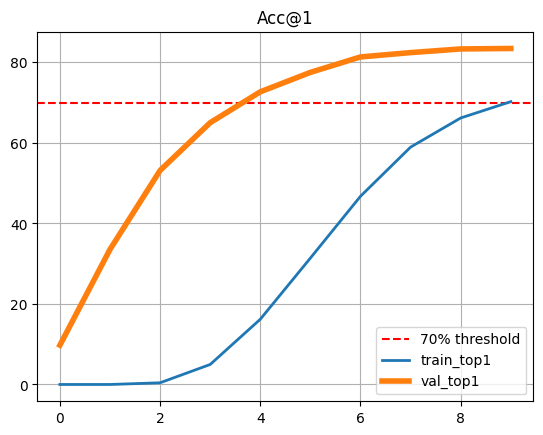

In [ ]:
plt.figure()
plt.axhline(70, color='red', ls='--', label='70% threshold')
for lw, (k, v) in enumerate(list(history_arcface.items())[2:], start=1):
  plt.plot(v, label=k, lw=lw * 2)
plt.title('Acc@1')
plt.grid()
plt.legend();

## Загрузка обученной модели и демонстрация

In [25]:
!gdown 1L03l0xK10sHChe42NKfMkLG4dgn7Qx7X

Downloading...
From (original): https://drive.google.com/uc?id=1L03l0xK10sHChe42NKfMkLG4dgn7Qx7X
From (redirected): https://drive.google.com/uc?id=1L03l0xK10sHChe42NKfMkLG4dgn7Qx7X&confirm=t&uuid=938577a7-799f-4f57-aa97-a033f86e199e
To: /content/face_embedding_model.pth
100% 140M/140M [00:03<00:00, 38.4MB/s]


In [26]:
model_, metadata_ = load_arcface_model_for_training(
    num_classes=NUM_CLASSES,
    checkpoint_path='face_embedding_model.pth')

Загрузка модели из чекпоинта: face_embedding_model.pth


In [ ]:
batch_size_ = 24
loader_ = DataLoader(val_ds, batch_size=batch_size_, shuffle=True)
load_ = iter(loader_)

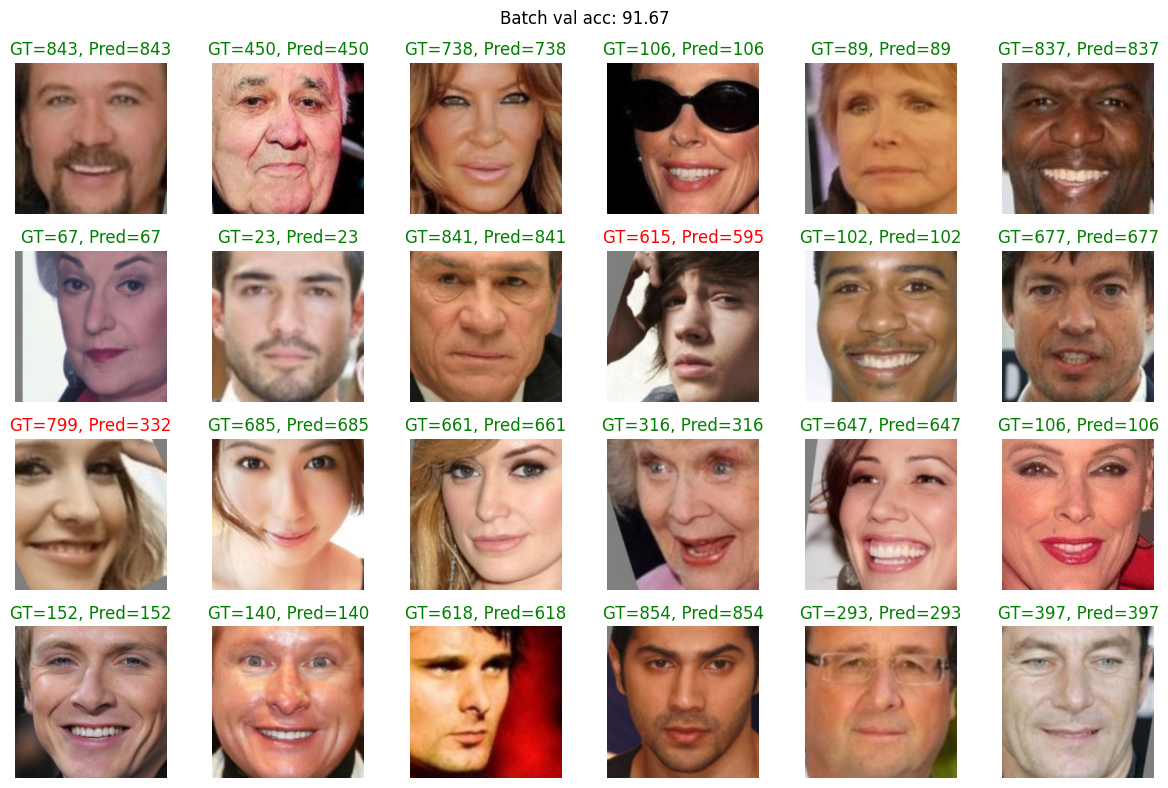

In [ ]:
model_.eval()

with torch.no_grad():
    images, labels = next(load_)
    logits = model_(images.to(DEVICE))
    preds = logits.cpu().argmax(1)

images = denormalize(images)

batch_val_acc = calculate_accuracy(logits, labels.cuda())

fig, ax = plt.subplots(4, 6, figsize=(12, 8))
ax = ax.flatten()
for i, img in enumerate(images):
    ax[i].imshow(img.permute(1,2,0));
    ax[i].axis('off')
    label, pred = labels[i], preds[i]
    c = 'green' if label == pred else 'red'
    ax[i].set_title(f'GT={label}, Pred={pred}', color=c)
fig.suptitle(f'Batch val acc: {(batch_val_acc):.2f}')
fig.tight_layout()

fig.show()

Модель с реализацией ArcFace успешно (val_acc@1 = 83.42%) справляется с распознаванием и классификацией лиц. Требуемый порог в 70% пройден.

Использование ArcFace без изменения гиперпараметров при идентичной архитектуре модели (включая размер эмбеддингов) позволило повысить качество предсказания на 2.84 п.п. (acc@1: 80.58% -> 83.42%) на валидационном наборе.

# Результаты

Были поставлены следующие задачи:

* Выбрать модель (или несколько моделей) для обучения. Можно брать предобученные на ImageNet, но нельзя использовать модели, предобученные на задачу распознавания лиц.
* Обучить эту модель (модели) на CE loss. Добиться accuracy > 0.7.
* Реализовать ArcFace loss.
* Обучить модель (модели) на ArcFace loss. Добиться accuracy > 0.7.
* Написать небольшой отчет по обучению, сравнить CE loss и ArcFace loss.

Задачи успешно выполнены, получены следующие результаты:
1. Построена бэйзлайн-модель на базе архитектуры ResNet18, предобученная на наборе данных ImageNet. Архитектура ResNet18 используется как backbone, где выход слоя AvgPool передается на вход эмбеддинг-слою, а его выход -- на вход полносвязному классификатору. Выбор архитектуры обусловлен ее небольшим весом при приемлемой производительности для данной задачи.
2. Модель обучена на наборе данных из предшествующего этапа (за исключением отложенной/тестовой выборки в 100 классов / 1999 изображений; т.е. при обучении и валидации использован набор, включающий в себя 18,001 изображений и 900 классов) с использованием "чистого" CE loss. За 10 эпох обучения метрика acc@1 на валидационном наборе достигла значения **80.58% (или 0.8058)**, что превышает требуемый порог качества в 0.7. Использование метрики acc валидно, поскольку набор сбалансирован по целевой переменной. Модель сохранена.
3. Реализован слой ArcFace. В модели он использовался одновременно вместо слоя эмбеддингов и линейного классификатора, на вход принимая выход backbone (AvgPool-слой ResNet18) при валидации и также истинные метки классов при обучении. Для расчета потерь также используется CE loss.
4. Модель с интеграцией ArcFace-слоя при идентичной в остальном архитектуре обучена на том же наборе данных с теми же гиперпараметрами. За 10 эпох обучения метрика acc@1 на валидационном наборе достигла значения **83.42% (или 0.8342)**, что превышает требуемый порог качества в 0.7 и одновременно превосходит показатели качества бэйзлайн-модели. Модель сохранена.
5. В первом случае (бэйзлайн) наблюдается переобучение, во втором же в силу различного расчета потерь при обучении/валидации (из-за маржина `m` при обучении, в частности) наблюдается ситуация, когда метрики на обучающей выборке существенно отстают от таковых на валидационной. Предположительно, к 15-20-й эпохе значения бы сравнялись -- либо поменялись местами, т.е. качество предсказания на обучающей превысило бы качество на валидационной, однако такого эксперимента не проводилось, так что утверждать нельзя. Характер графиков, в то же время, позволяет предположить, что к 10-й эпохе обе модели уже вышли на плато или были близки к нему, т.е. и дальнейший прирост качества был бы, вероятно, пренебрежимо мал в обоих случаях (либо следовало бы ожидать снижения его на валидационной выборке). При этом использование ArcFace в данном сетапе **позволило добиться заметного прироста качества (чуть менее 3 п.п.) без переобучения**, в связи с чем на следующем этапе будет использована именно эта модель.
6. Дополнительно выделен тестовый набор данных в размере 1999 изображений (100 классов) для реализации ID rate metric. Набор сохранен.

**Материальные результаты**:
1. Отложенный (тестовый) набор данных в виде файла `df_aligned_test.csv` (1999 строк, столбцы `image_id` и `identity`): https://drive.google.com/file/d/1EbMnP6t03hWucXWRornq4L-H0gUcrRDF/view?usp=drive_link
2. Обученная бэйзлайн-модель для распознавания лиц: https://drive.google.com/file/d/1JS-qiBff163-0wTMQJ08hkGtQnWxzWgb/view?usp=drive_link
3. Обученная ArcFace-модель для распознавания лиц: https://drive.google.com/file/d/1L03l0xK10sHChe42NKfMkLG4dgn7Qx7X/view?usp=drive_link